# Welcome to Tryolabs' machine learning interview

If you are here, it's because your profile has already caught our attention. Congratulations!
This is a test so we can better learn about your skills by having you solve a real Machine Learning problem. The outcome is not the most important thing, we want to see your thought process and how you approach the problem, so make sure you write down everything you evaluate to do, approaches that didn't work, etc

# The project

The problem we want to analyze is based on [this Kaggle competition](https://www.kaggle.com/c/plant-seedlings-classification). Bear in mind you will have 12 hours of GPU to train this notebook.

# What we expect

There are 2 stages to the solution we want you to achieve.

## Stage #1

* An end to end solution, this means you need to be able to understand the description of the problem from the description of the competition, download the dataset, pick a model suitable for this problem, train it, and evaluate the results.
* We'll pay special attention to code quality and common pitfalls.
* You need to be able to explain each step and why it is there.
* Explain the data analysis you performed.


> Note: we are not aiming for the best-performing model but a reasonable one, so make sure you don't fall into a rabbit hole fine-tuning too much. We value more the understanding of how you approached the problem and how you faced the issues within the dataset. Make sure to document your thought process.

## Stage #2

We'd like that you evaluate if a preprocessing with a Zero Shot Segmentation Model can improve the results obtained in Stage #1. For this we want you to:

* Pick at least two Zero Shot Segmentation models, then comment and compare them in the context of the previous task
* Incorporate the selected Zero Shot Segmentation model to the end to end solution of stage #1
* Evaluate the results you obtained

> Note: we do not expect that you implement the Zero Shot Segmentation models, pick a pre trained model or an off the shelf product and use them directly.


# The extra mile

* Carry on a dataset inconsistencies analysis.
* Explain what the models are taking into account to generate the predictions.
* In depth error analysis.

# The dataset

To make it accessible from your Colab notebook you need to mount your Drive:
```python
from google.colab import drive
drive.mount('/content/drive')
```
To check if you can access it from the notebook run:
```bash
%ls /content/drive/'My Drive'/Tryolabs-CV-Interview/data
```

To learn more about how Colab works check [this guide](https://colab.research.google.com/notebooks/welcome.ipynb).

# Imports

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install transformers


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-rm6mtxo9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-rm6mtxo9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=cf2572bc965ed6752f4f4d8dc3c8ee3755b464169fa25c2ae87e0115209d76e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-ijpw_hk9/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [2]:
# Standard Python Libraries
import os
import math
import random
import zipfile
from collections import Counter

# Data Science & Image Processing
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, GlobalAveragePooling2D
)
from tensorflow.keras.applications import EfficientNetB0, VGG19, ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# PyTorch & Segmentation Models
import torch
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import zipfile

zip_path = "/content/drive/My Drive/plant-seedlings-classification.zip"  # Path to the ZIP file
extract_path = "/content/plant-seedlings-classification"  # Destination folder in Colab

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed.")



Extraction completed.


In [5]:
os.listdir(extract_path)


['test', 'train', 'sample_submission.csv']

# **Stage #1 - End-to-End Classification Model**  

In this stage, an **end-to-end pipeline** for plant seedling classification was developed.  

Exploratory Data Analysis (EDA) was performed to analyze class distribution and image properties.

Different models were tested, including a **custom CNN** and **EfficientNetB0**, before selecting **VGG19** for fine-tuning.
  
Techniques such as **data augmentation**, **class balancing**, and **learning rate adjustments** were applied to optimize performance.


## Exploratory Data Analysis *(EDA)*  

Understanding the dataset is essential before training the model.  

Key steps in this phase:  

- **Class Distribution Analysis**: Identifying the number of images per class to detect imbalance.  

- **Sample Visualization**: Checking data quality, variability, and potential noise.  

- **Preprocessing Considerations**: Evaluating image sizes and deciding on standardization.  



In [6]:
train_path = os.path.join(extract_path, "train")
classes = os.listdir(train_path)

print(f"Classes found: {classes}")


Classes found: ['Shepherds Purse', 'Fat Hen', 'Maize', 'Loose Silky-bent', 'Cleavers', 'Scentless Mayweed', 'Black-grass', 'Charlock', 'Small-flowered Cranesbill', 'Common Chickweed', 'Common wheat', 'Sugar beet']


In [7]:
# Count the number of images per class
class_counts = {class_name: len(os.listdir(os.path.join(train_path, class_name))) for class_name in classes}

# Display the class distribution
class_counts


{'Shepherds Purse': 231,
 'Fat Hen': 475,
 'Maize': 221,
 'Loose Silky-bent': 654,
 'Cleavers': 287,
 'Scentless Mayweed': 516,
 'Black-grass': 263,
 'Charlock': 390,
 'Small-flowered Cranesbill': 496,
 'Common Chickweed': 611,
 'Common wheat': 221,
 'Sugar beet': 385}

<ipython-input-8-a4b06474d16d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_class_counts["Class"], y=df_class_counts["Count"], palette="viridis")


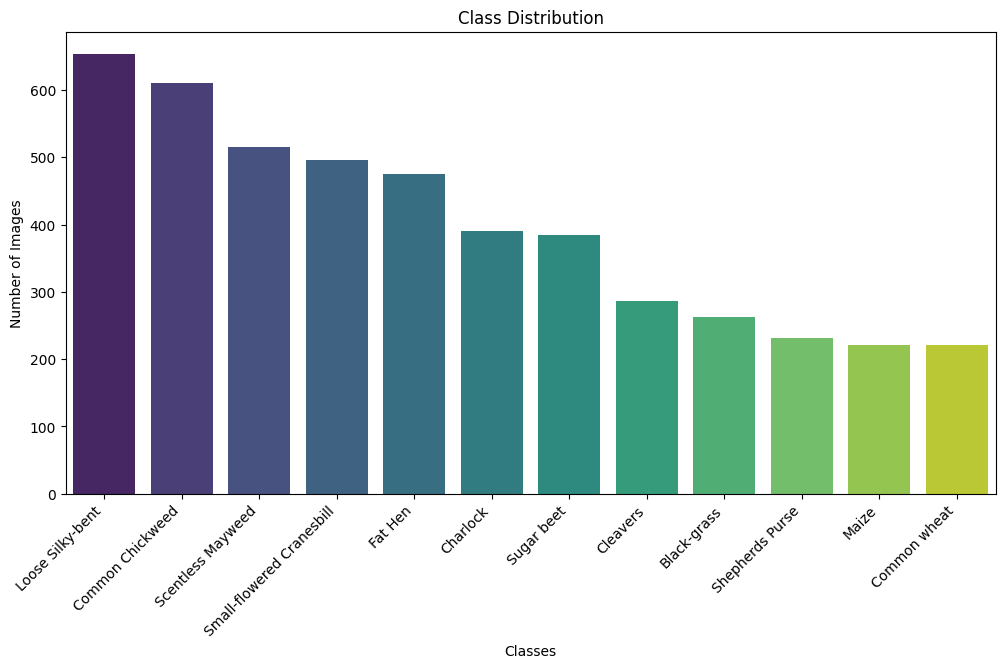

In [8]:
# Convert class counts into a DataFrame
df_class_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
df_class_counts = df_class_counts.sort_values(by="Count", ascending=False)

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=df_class_counts["Class"], y=df_class_counts["Count"], palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()


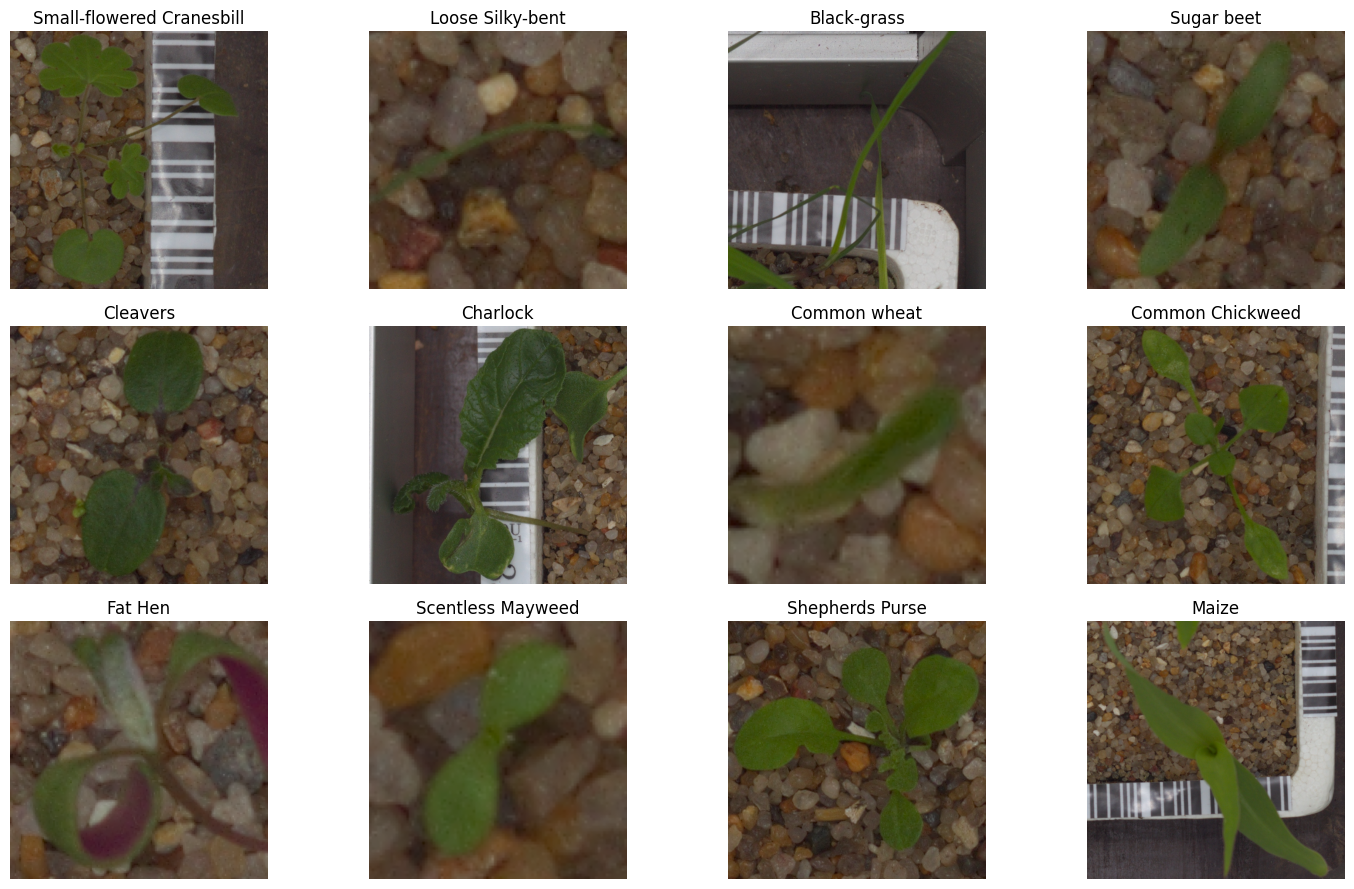

In [10]:
# Filter classes that contain images
classes_with_images = [cls for cls in classes if len(os.listdir(os.path.join(train_path, cls))) > 0]

num_classes = len(classes_with_images)
num_cols = 4  # Fixed number of columns
num_rows = math.ceil(num_classes / num_cols)  # Adjust rows dynamically

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3 * num_rows))

# Flatten the axes array and iterate through available classes with images
axes = axes.flatten()
for i, cls in enumerate(random.sample(classes_with_images, num_classes)):
    img_list = os.listdir(os.path.join(train_path, cls))
    img_path = os.path.join(train_path, cls, random.choice(img_list))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis("off")

# Hide empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

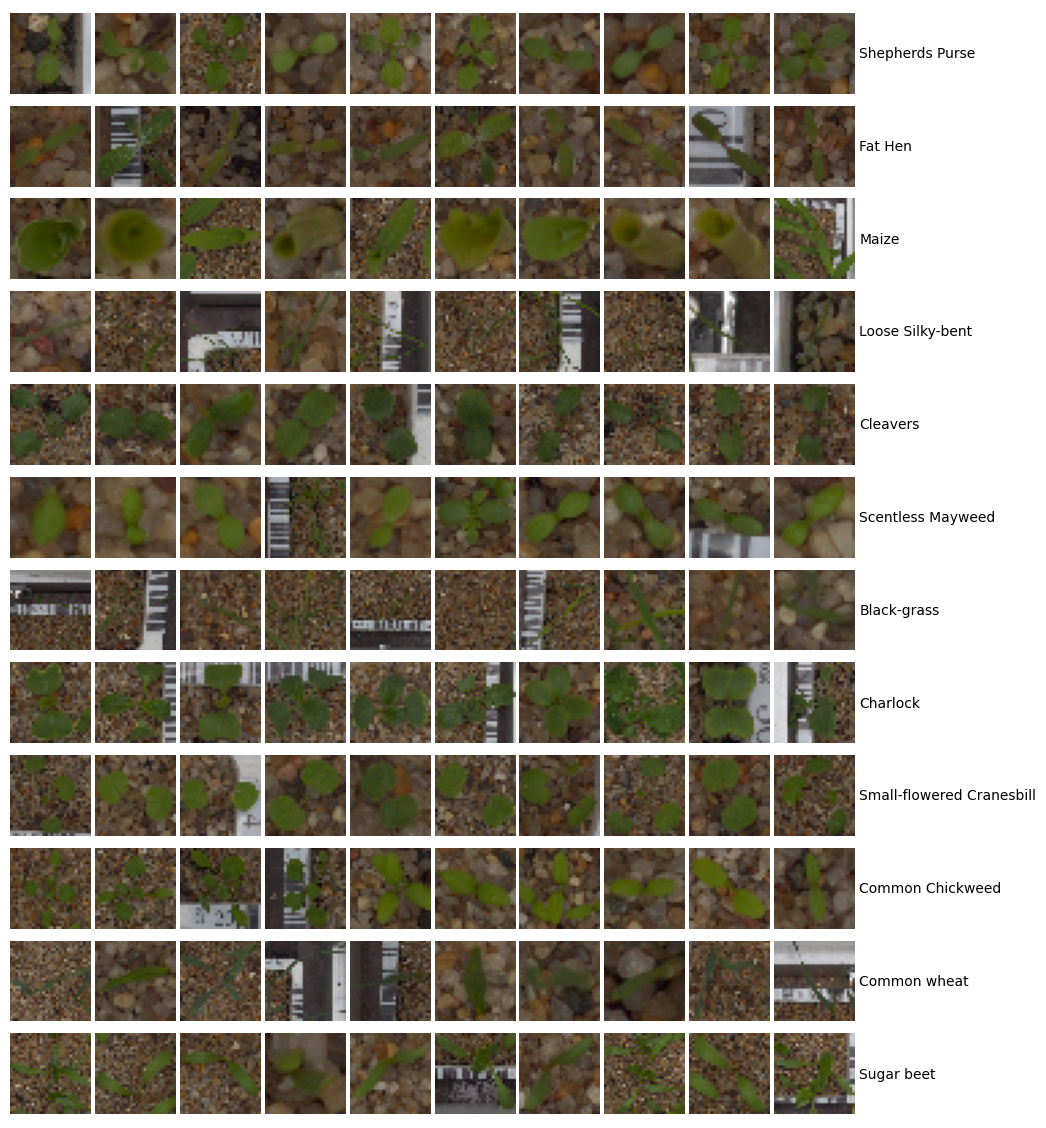

In [11]:
num_imgs_per_class = 10
img_size = (30, 30)
num_cols = num_imgs_per_class
num_rows = len(classes_with_images)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols + 1, figsize=(12, 1.2 * num_rows))

for row_idx, cls in enumerate(classes_with_images):
    img_list = os.listdir(os.path.join(train_path, cls))
    selected_imgs = random.sample(img_list, min(num_imgs_per_class, len(img_list)))

    # Display images of the class
    for col_idx, img_name in enumerate(selected_imgs):
        img_path = os.path.join(train_path, cls, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)  # Resize images for better visualization

        axes[row_idx, col_idx].imshow(img)
        axes[row_idx, col_idx].axis("off")

    # Add class name in the last column
    axes[row_idx, -1].text(0, 0.5, cls, fontsize=10, va='center', ha='left')
    axes[row_idx, -1].axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()



In [12]:
image_shapes = []

# Check image sizes in a subset of the dataset
for cls in classes:
    img_list = os.listdir(os.path.join(train_path, cls))[:5]  # Sample 5 images per class
    for img_name in img_list:
        img_path = os.path.join(train_path, cls, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            image_shapes.append(img.shape[:2])  # Store dimensions (height, width)

# Convert to array for statistical analysis
image_shapes = np.array(image_shapes)
print(f"Average image size: {np.mean(image_shapes, axis=0)}")
print(f"Minimum size: {np.min(image_shapes, axis=0)}")
print(f"Maximum size: {np.max(image_shapes, axis=0)}")

Average image size: [343.8 343.8]
Minimum size: [58 58]
Maximum size: [1485 1485]


### Image Preprocessing  

**ImageDataGenerator** for normalizing, resizing, and applying data augmentation techniques.  
This improves model generalization by introducing variations in the training images.  


In [13]:
IMG_SIZE = (128, 128)  # Standard input size for the model
BATCH_SIZE = 32

# Image generator with augmentation and resizing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split: 80% training / 20% validation
)

# Create training and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,  # Resize all images to 128x128
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Display detected classes
print(f"Classes found: {train_generator.class_indices}")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Classes found: {'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}


### Image Size Analysis  

Checking image dimensions after preprocessing to ensure consistency.  
This helps verify that all images are resized correctly before training.  


In [14]:
# Batch of images from the training generator
batch_images, batch_labels = next(train_generator)

# Extract image dimensions
image_shapes = np.array([img.shape[:2] for img in batch_images])

# Print image size statistics
print(f"Average image size: {np.mean(image_shapes, axis=0)}")
print(f"Minimum image size: {np.min(image_shapes, axis=0)}")
print(f"Maximum image size: {np.max(image_shapes, axis=0)}")

Average image size: [128. 128.]
Minimum image size: [128 128]
Maximum image size: [128 128]


In [15]:
# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Compute class weights based on class distribution
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(class_labels)),
    y=train_generator.classes  # Get class labels from training data
)

# Convert to dictionary with class indices
class_weights_dict = {i: class_weights_array[i] for i in range(len(class_labels))}

print(f"Computed class weights: {class_weights_dict}")

Computed class weights: {0: 1.5019747235387046, 1: 1.015758547008547, 2: 1.3778985507246377, 3: 0.648091342876619, 4: 1.7904896421845575, 5: 0.8339912280701754, 6: 0.6048027989821882, 7: 1.7904896421845575, 8: 0.7673527037933817, 9: 1.713063063063063, 10: 0.7982787573467675, 11: 1.0289502164502164}


In [16]:
# Number of images per class in the training generator
train_count = np.sum(train_generator.labels[:, None] == np.arange(len(train_generator.class_indices)), axis=0)

# Number of images per class in the validation generator
val_count = np.sum(val_generator.labels[:, None] == np.arange(len(val_generator.class_indices)), axis=0)

# Print class distribution in training and validation sets
for class_name, idx in train_generator.class_indices.items():
    print(f"Class: {class_name} - Training: {train_count[idx]} - Validation: {val_count[idx]}")

Class: Black-grass - Training: 211 - Validation: 52
Class: Charlock - Training: 312 - Validation: 78
Class: Cleavers - Training: 230 - Validation: 57
Class: Common Chickweed - Training: 489 - Validation: 122
Class: Common wheat - Training: 177 - Validation: 44
Class: Fat Hen - Training: 380 - Validation: 95
Class: Loose Silky-bent - Training: 524 - Validation: 130
Class: Maize - Training: 177 - Validation: 44
Class: Scentless Mayweed - Training: 413 - Validation: 103
Class: Shepherds Purse - Training: 185 - Validation: 46
Class: Small-flowered Cranesbill - Training: 397 - Validation: 99
Class: Sugar beet - Training: 308 - Validation: 77


## Model Development  
With the preprocessed data, we move on to building and training the models.  

- **Training a CNN from scratch** to learn features directly from the dataset.  

- **Transfer Learning** with pre-trained models to compare performance.  

- **Optimizing training** with techniques like Early Stopping and Hyperparameter Tuning.  




In [19]:
cnn_model = Sequential([
    # First convolutional block with batch normalization and regularization
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    # Second convolutional block
    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    # Third convolutional block with increased filter depth
    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    # Fourth convolutional block
    Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    # Flatten the data for the dense layers
    Flatten(),

    # Fully connected layers with dropout for better generalization
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    # Output layer with 12 neurons and softmax activation
    Dense(12, activation='softmax')
])

# Compile the model with Adam optimizer and categorical loss
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,784,332 (10.62 MB)

 Trainable params: 2,783,372 (10.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [20]:
# Early Stopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Reduce learning rate dynamically when `val_loss` stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model including class weights
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    batch_size=32,
    class_weight=class_weights_dict,  # Adjust class imbalance
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 75s 563ms/step - accuracy: 0.1304 - loss: 5.6036 - val_accuracy: 0.0581 - val_loss: 3.7665 - learning_rate: 0.0010
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 510ms/step - accuracy: 0.2086 - loss: 3.6059 - val_accuracy: 0.0475 - val_loss: 6.1699 - learning_rate: 0.0010
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 62s 521ms/step - accuracy: 0.2630 - loss: 3.2146 - val_accuracy: 0.1447 - val_loss: 4.1872 - learning_rate: 0.0010
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 512ms/step - accuracy: 0.2970 - loss: 3.0926 - val_accuracy: 0.1943 - val_loss: 3.9400 - learning_rate: 0.0010
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 513ms/step - accuracy: 0.3278 - loss: 2.9149 - val_accuracy: 0.4435 - val_loss: 2.7511 - learning_rate: 5.0000e-04
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 510ms/step - accuracy: 0.3756 - loss: 2.7551 - val_accuracy: 0.4065 - val_loss: 2.6552 - learning_rate: 5.0000e-04
Epoch 7/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 510ms/step - accur

In [21]:
# Freeze initial layers and train only the last ones
for layer in cnn_model.layers[:-5]:
    layer.trainable = False  # Keep earlier layers frozen

# Compile with a lower learning rate for fine-tuning
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Continue training with fine-tuning
history_cnn_finetuned = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # More focused fine-tuning
    batch_size=32,
    callbacks=[early_stopping]
)

# Save the fine-tuned model
cnn_model.save("/content/drive/MyDrive/cnn_finetuned_v0.h5")

print("Fine-Tuning completed. Model saved as cnn_finetuned_v0.h5")

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 68s 539ms/step - accuracy: 0.8342 - loss: 0.8348 - val_accuracy: 0.8796 - val_loss: 0.7448
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 512ms/step - accuracy: 0.8664 - loss: 0.7627 - val_accuracy: 0.8912 - val_loss: 0.7207
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 510ms/step - accuracy: 0.8667 - loss: 0.7217 - val_accuracy: 0.8997 - val_loss: 0.7041
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 512ms/step - accuracy: 0.8791 - loss: 0.7065 - val_accuracy: 0.9007 - val_loss: 0.7072
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 519ms/step - accuracy: 0.8653 - loss: 0.6937 - val_accuracy: 0.8965 - val_loss: 0.6946
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 512ms/step - accuracy: 0.8794 - loss: 0.7021 - val_accuracy: 0.8933 - val_loss: 0.6978
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 510ms/step - accuracy: 0.8563 - loss: 0.7177 - val_accuracy: 0.9018 - val_loss: 0.6765
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 509ms/step - accuracy: 0.8785 - loss: 0

Fine-Tuning completed. Model saved as cnn_finetuned_v0.h5


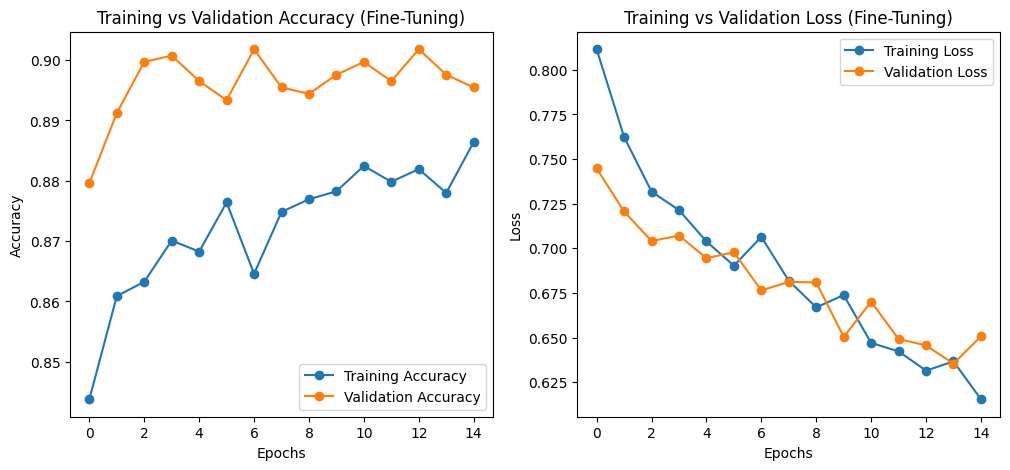

In [22]:
# Extract training and validation metrics from fine-tuning phase
history_dict_finetuned = history_cnn_finetuned.history
acc_finetuned = history_dict_finetuned['accuracy']
val_acc_finetuned = history_dict_finetuned['val_accuracy']
loss_finetuned = history_dict_finetuned['loss']
val_loss_finetuned = history_dict_finetuned['val_loss']

epochs_range_finetuned = range(len(acc_finetuned))

# Visualization of Accuracy and Loss for Fine-Tuning
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range_finetuned, acc_finetuned, label='Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs_range_finetuned, val_acc_finetuned, label='Validation Accuracy', linestyle='-', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title("Training vs Validation Accuracy (Fine-Tuning)")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range_finetuned, loss_finetuned, label='Training Loss', linestyle='-', marker='o')
plt.plot(epochs_range_finetuned, val_loss_finetuned, label='Validation Loss', linestyle='-', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training vs Validation Loss (Fine-Tuning)")

plt.show()

### Implementing Transfer Learning  

After training a CNN from scratch, Transfer Learning was applied using pre-trained models from ImageNet.  
Both **EfficientNetB0** and **VGG19** were tested to evaluate their performance.  

- **EfficientNetB0** struggled to achieve high accuracy, showing slow convergence.  
- **VGG19** delivered better results, and Fine-Tuning further enhanced performance.  

This iterative approach helped refine model selection and optimize classification accuracy.



#### Implementing EfficientNetB0 with Fine-Tuning  

EfficientNetB0 is used as a pre-trained model for feature extraction.  
Only the last layers are unfrozen for fine-tuning while maintaining learned features from ImageNet.  


In [24]:
# Load the pre-trained EfficientNetB0 model without the top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze only the last 50 layers for Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False  # Keep earlier layers frozen

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5, name="dropout")(x, training=True)
output_layer = Dense(12, activation='softmax')(x)

eff_model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model using Adam optimizer for better adaptation
eff_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model with Fine-Tuning
history_eff_tuned = eff_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the trained model after first fine-tuning phase
eff_model.save("/content/drive/MyDrive/efficientnet_finetuned_v0.h5")

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 127s 777ms/step - accuracy: 0.0925 - loss: 2.5378 - val_accuracy: 0.0813 - val_loss: 2.4700 - learning_rate: 1.0000e-04
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 513ms/step - accuracy: 0.1171 - loss: 2.4718 - val_accuracy: 0.1373 - val_loss: 2.4271 - learning_rate: 1.0000e-04
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 512ms/step - accuracy: 0.1326 - loss: 2.4613 - val_accuracy: 0.1067 - val_loss: 2.4372 - learning_rate: 1.0000e-04
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 512ms/step - accuracy: 0.1220 - loss: 2.4486 - val_accuracy: 0.1404 - val_loss: 2.4321 - learning_rate: 1.0000e-04
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 512ms/step - accuracy: 0.1335 - loss: 2.4497 - val_accuracy: 0.1288 - val_loss: 2.4206 - learning_rate: 1.0000e-04
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 62s 515ms/step - accuracy: 0.1274 - loss: 2.4487 - val_accuracy: 0.1373 - val_loss: 2.4180 - learning_rate: 1.0000e-04
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 5

#### Implementing VGG19 with Fine-Tuning  

VGG19 is used as a pre-trained model for feature extraction.  

At first only the last 10 layers are unfrozen to allow fine-tuning while retaining learned features from ImageNet.  

Additional fully connected layers are added to adapt the model for plant seedling classification.  


In [27]:
# Load the pre-trained VGG19 model without the top classification layer
base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model_vgg.trainable = True
for layer in base_model_vgg.layers[:-15]:
    layer.trainable = False

# Add custom classification layers
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
output_layer = Dense(12, activation='softmax')(x)

vgg_model = Model(inputs=base_model_vgg.input, outputs=output_layer)

# Compile the model with Adam optimizer
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_vgg_tuned = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the trained model
vgg_model.save("/content/drive/MyDrive/vgg19_finetuned_v0.h5")

print("Training completed. Model saved as vgg19_finetuned_v0.h5")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,295,244 (77.42 MB)

 Trainable params: 20,034,060 (76.42 MB)

 Non-trainable params: 261,184 (1020.25 KB)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 93s 649ms/step - accuracy: 0.2066 - loss: 2.4569 - val_accuracy: 0.1320 - val_loss: 2.3657 - learning_rate: 5.0000e-05
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 516ms/step - accuracy: 0.4904 - loss: 1.5300 - val_accuracy: 0.6230 - val_loss: 1.8138 - learning_rate: 5.0000e-05
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 513ms/step - accuracy: 0.6516 - loss: 1.0229 - val_accuracy: 0.6410 - val_loss: 1.3603 - learning_rate: 5.0000e-05
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 514ms/step - accuracy: 0.7477 - loss: 0.7775 - val_accuracy: 0.6167 - val_loss: 1.1600 - learning_rate: 5.0000e-05
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 511ms/step - accuracy: 0.7907 - loss: 0.5952 - val_accuracy: 0.6705 - val_loss: 0.9149 - learning_rate: 5.0000e-05
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 513ms/step - accuracy: 0.8167 - loss: 0.5452 - val_accuracy: 0.8205 - val_loss: 0.5302 - learning_rate: 5.0000e-05
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 62s 51

Training completed. Model saved as vgg19_finetuned_v0.h5


In [28]:
model_path = "/content/drive/MyDrive/vgg19_finetuned_v0.h5"
vgg_model_finetuned = load_model(model_path)

# Unfreeze even more layers for deeper fine-tuning
vgg_model_finetuned.trainable = True
for layer in vgg_model_finetuned.layers[:-25]:
    layer.trainable = False

vgg_model_finetuned.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-7),  # Reduced LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_vgg_finetuned = vgg_model_finetuned.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the updated model
vgg_model_finetuned.save("/content/drive/MyDrive/vgg19_finetuned_final.h5")

# Evaluate the model after training
evaluation = vgg_model_finetuned.evaluate(val_generator)
print(f"Training completed. Model saved as vgg19_finetuned_final.h5")
print(f"Final Validation Accuracy: {evaluation[1]}")



Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 72s 549ms/step - accuracy: 0.9460 - loss: 0.1496 - val_accuracy: 0.9303 - val_loss: 0.2337 - learning_rate: 5.0000e-07
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 514ms/step - accuracy: 0.9468 - loss: 0.1458 - val_accuracy: 0.9250 - val_loss: 0.2382 - learning_rate: 5.0000e-07
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 62s 520ms/step - accuracy: 0.9563 - loss: 0.1352 - val_accuracy: 0.9261 - val_loss: 0.2340 - learning_rate: 5.0000e-07
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 515ms/step - accuracy: 0.9594 - loss: 0.1168 - val_accuracy: 0.9293 - val_loss: 0.2384 - learning_rate: 5.0000e-07
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 515ms/step - accuracy: 0.9585 - loss: 0.1201 - val_accuracy: 0.9282 - val_loss: 0.2255 - learning_rate: 2.5000e-07
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 513ms/step - accuracy: 0.9562 - loss: 0.1304 - val_accuracy: 0.9345 - val_loss: 0.2312 - learning_rate: 2.5000e-07
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 51

30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 0.9201 - loss: 0.2476
Training completed. Model saved as vgg19_finetuned_final.h5
Final Validation Accuracy: 0.9250264167785645


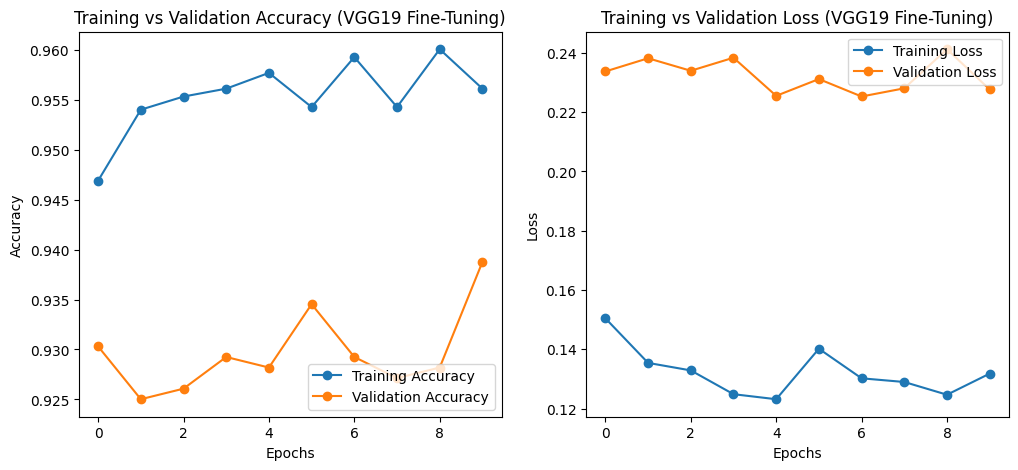

In [29]:
# Extract training and validation metrics from fine-tuning phase of VGG19
history_dict_vgg_finetuned = history_vgg_finetuned.history
acc_vgg_finetuned = history_dict_vgg_finetuned['accuracy']
val_acc_vgg_finetuned = history_dict_vgg_finetuned['val_accuracy']
loss_vgg_finetuned = history_dict_vgg_finetuned['loss']
val_loss_vgg_finetuned = history_dict_vgg_finetuned['val_loss']

epochs_range_vgg_finetuned = range(len(acc_vgg_finetuned))

# Visualization of Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range_vgg_finetuned, acc_vgg_finetuned, label='Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs_range_vgg_finetuned, val_acc_vgg_finetuned, label='Validation Accuracy', linestyle='-', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title("Training vs Validation Accuracy (VGG19 Fine-Tuning)")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range_vgg_finetuned, loss_vgg_finetuned, label='Training Loss', linestyle='-', marker='o')
plt.plot(epochs_range_vgg_finetuned, val_loss_vgg_finetuned, label='Validation Loss', linestyle='-', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training vs Validation Loss (VGG19 Fine-Tuning)")

plt.show()


# **Stage #2: Zero Shot Segmentation for Improved Classification**
In this stage, we explore whether **Zero Shot Segmentation** can enhance our classification model.

By leveraging **SAM (Segment Anything Model) and CLIPSeg**, we preprocess the dataset to improve feature extraction for VGG19.

### Improving Classification with Zero Shot Segmentation  
Applying **SAM** & **CLIPSeg** to Enhance Plant Recognition  


In [31]:
# Selecting a random class and an image within that class
sample_class = random.choice(classes)
sample_image = random.choice(os.listdir(os.path.join(train_path, sample_class)))
img_path = os.path.join(train_path, sample_class, sample_image)

print("Selected image:", img_path)

Selected image: /content/plant-seedlings-classification/train/Shepherds Purse/3e34f0e4d.png


In [32]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


--2025-02-09 07:09:54--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.111, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   197MB/s    in 13s     

2025-02-09 07:10:07 (185 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [33]:
# Path to the downloaded model checkpoint
sam_checkpoint = "sam_vit_h_4b8939.pth"

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained SAM model
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to(device)

# Initialize the automatic mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

print("SAM successfully loaded")


/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


SAM successfully loaded


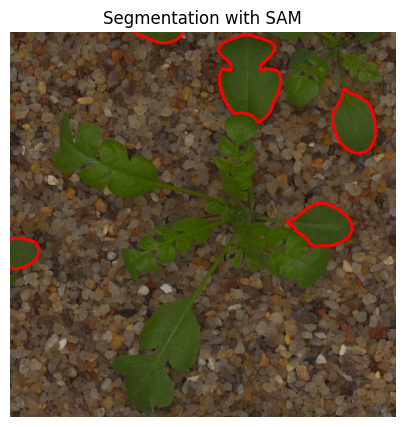

Segmentation completed. 674 masks found.


In [34]:
# Load the image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Generate masks using SAM
masks = mask_generator.generate(image)

plt.figure(figsize=(10, 5))
plt.imshow(image)

for mask in masks[:5]:
    plt.contour(mask["segmentation"], colors='r', linewidths=2)

plt.title("Segmentation with SAM")
plt.axis("off")
plt.show()

print(f"Segmentation completed. {len(masks)} masks found.")

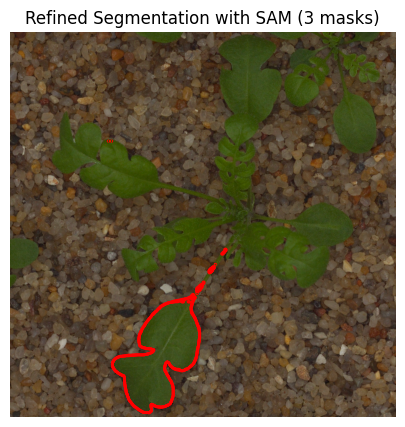

Optimized segmentation. Displaying 3 relevant masks.


In [35]:
# Ensure `masks` contains data before proceeding
if 'masks' in globals() and len(masks) > 0:
    # Set a minimum area threshold (adjustable based on images)
    mask_threshold = 5000

    # Filter out larger masks and remove noise
    filtered_masks = [mask for mask in masks if np.sum(mask["segmentation"]) > mask_threshold]

    # Sort by size and keep only the most relevant ones
    filtered_masks = sorted(filtered_masks, key=lambda x: np.sum(x["segmentation"]), reverse=True)[:3]

    if len(filtered_masks) > 0:
        # Display the image with refined segmentation
        plt.figure(figsize=(10, 5))
        plt.imshow(image)

        for mask in filtered_masks:
            plt.contour(mask["segmentation"], colors='r', linewidths=2)

        plt.title(f"Refined Segmentation with SAM ({len(filtered_masks)} masks)")
        plt.axis("off")
        plt.show()

        print(f"Optimized segmentation. Displaying {len(filtered_masks)} relevant masks.")
    else:
        print("No relevant masks found after filtering.")
else:
    print("Error: 'masks' is not defined or contains no data. Ensure segmentations have been generated.")


In [36]:
# Define the device (use GPU if available, otherwise default to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained CLIPSeg model processor
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

# Load the CLIPSeg model for image segmentation and move it to the selected device
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)

print(f"CLIPSeg successfully loaded on: {device}")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

CLIPSeg successfully loaded on: cuda


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)


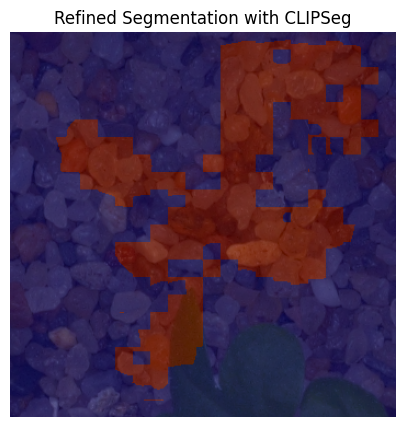

In [39]:
image = Image.open(img_path).convert("RGB")  # RGB format

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64").to(device)

prompt = "plant"

inputs = processor(text=[prompt], images=image, return_tensors="pt", padding=True, truncation=True).to(device)

with torch.no_grad():
    outputs = model(**inputs)

threshold = 0.5  # Adjust based on segmentation quality
binary_mask = (outputs.logits[0].sigmoid().cpu().detach().numpy() > threshold).astype(np.uint8)

binary_mask_cv2 = (binary_mask * 255).astype(np.uint8)

kernel = np.ones((5, 5), np.uint8)  # Structuring element
processed_mask = cv2.morphologyEx(binary_mask_cv2, cv2.MORPH_CLOSE, kernel)  # Remove small holes

# Display the original image with the refined segmentation mask
plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.imshow(processed_mask, alpha=0.5, cmap="jet")  # Overlay the processed mask
plt.title("Refined Segmentation with CLIPSeg")
plt.axis("off")
plt.show()



In [40]:
input_dir = "/content/plant-seedlings-classification/train"
output_dir = "/content/drive/MyDrive/clipseg_segmented_final"
os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)

# Iterate through all images in the dataset
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)  # Create an output directory per class

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        output_img_path = os.path.join(output_class_dir, img_name)

        if os.path.exists(output_img_path):
            print(f"Skipping already segmented image: {output_img_path}")
            continue

        # Load image and convert to RGB
        image = Image.open(img_path).convert("RGB")

        # Process the image with CLIPSeg
        inputs = processor(text=["plant"], images=image, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        # Generate the segmentation mask
        mask = outputs.logits[0].sigmoid().cpu().detach().numpy()

        # Convert the mask to binary format (0 or 255)
        binary_mask = (mask > 0.5).astype(np.uint8) * 255

        # Apply morphological operations to refine the mask
        kernel = np.ones((5, 5), np.uint8)  # Structuring element
        refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

        # Save the segmented image to Drive
        cv2.imwrite(output_img_path, refined_mask)

        print(f"Segmented image saved at: {output_img_path}")

print("\nSegmentation completed. Segmented images are stored at:", output_dir)


Segmented image saved at: /content/drive/MyDrive/clipseg_segmented_final/Shepherds Purse/63b3aba11.png
Segmented image saved at: /content/drive/MyDrive/clipseg_segmented_final/Shepherds Purse/bbeb86100.png
Segmented image saved at: /content/drive/MyDrive/clipseg_segmented_final/Shepherds Purse/9617b5025.png
Segmented image saved at: /content/drive/MyDrive/clipseg_segmented_final/Shepherds Purse/6fe09ced5.png
Segmented image saved at: /content/drive/MyDrive/clipseg_segmented_final/Shepherds Purse/6ce2cfd88.png
Segmented image saved at: /content/drive/MyDrive/clipseg_segmented_final/Shepherds Purse/c9457398b.png
Segmented image saved at: /content/drive/MyDrive/clipseg_segmented_final/Shepherds Purse/8d9512864.png
Segmented image saved at: /content/drive/MyDrive/clipseg_segmented_final/Shepherds Purse/afb08d410.png
Segmented image saved at: /content/drive/MyDrive/clipseg_segmented_final/Shepherds Purse/847872e08.png
Segmented image saved at: /content/drive/MyDrive/clipseg_segmented_final/

In [41]:
# Path for segmented images stored in Google Drive
segmented_data_path = "/content/drive/MyDrive/clipseg_segmented_final"

# Parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Create new image generators with controlled data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # 15° to avoid excessive deformation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.1,  # Shearing
    zoom_range=0.1,  # Zooming
    horizontal_flip=True,
    validation_split=0.2
)

# Generators for training and validation
train_generator = train_datagen.flow_from_directory(
    segmented_data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    segmented_data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Verify dataset loading
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

# Check that dataset structure is correct
print("Classes found:", os.listdir(segmented_data_path))



Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Training samples: 3803
Validation samples: 947
Classes found: ['Shepherds Purse', 'Fat Hen', 'Maize', 'Loose Silky-bent', 'Cleavers', 'Scentless Mayweed', 'Black-grass', 'Charlock', 'Small-flowered Cranesbill', 'Common Chickweed', 'Common wheat', 'Sugar beet']


Instead of training from scratch, this approach uses the previously fine-tuned VGG19 model.

In [42]:
# Load the previously trained model
model_path = "/content/drive/MyDrive/vgg19_finetuned_final.h5"
vgg_model_segmented = load_model(model_path)

vgg_model_segmented.trainable = True

vgg_model_segmented.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_vgg_segmented_finetuned = vgg_model_segmented.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Fine-Tuning for fewer epochs
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the updated model
vgg_model_segmented.save("/content/drive/MyDrive/vgg19_finetuned_segmentado_v0.h5")

print("Training completed. Model saved as vgg19_finetuned_segmentado_v0.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.2959 - loss: 2.2450 - val_accuracy: 0.3770 - val_loss: 1.9155 - learning_rate: 5.0000e-06
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 0.4522 - loss: 1.6195 - val_accuracy: 0.5185 - val_loss: 1.4751 - learning_rate: 5.0000e-06
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 247ms/step - accuracy: 0.5260 - loss: 1.4394 - val_accuracy: 0.5269 - val_loss: 1.4141 - learning_rate: 5.0000e-06
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 245ms/step - accuracy: 0.5697 - loss: 1.3130 - val_accuracy: 0.5744 - val_loss: 1.2626 - learning_rate: 5.0000e-06
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 0.5815 - loss: 1.2327 - val_accuracy: 0.5818 - val_loss: 1.2433 - learning_rate: 5.0000e-06
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 243ms/step - accuracy: 0.5926 - loss: 1.2152 - val_accuracy: 0.5723 - val_loss: 1.2924 - learning_rate: 5.0000e-06
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 24

Training completed. Model saved as vgg19_finetuned_segmentado_v0.h5


In [43]:
# Unfreeze more layers for better fine-tuning
for layer in vgg_model_segmented.layers[:-10]:
    layer.trainable = False

# Compile with lower learning rate
vgg_model_segmented.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with more epochs
history_vgg_segmented_finetuned = vgg_model_segmented.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the updated model
vgg_model_segmented.save("/content/drive/MyDrive/vgg19_finetuned_segmentado_v1.h5")

print("Training completed. Model saved as vgg19_finetuned_segmentado_v1.h5")

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 39s 284ms/step - accuracy: 0.6494 - loss: 1.0656 - val_accuracy: 0.6463 - val_loss: 1.0968 - learning_rate: 1.0000e-06
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 243ms/step - accuracy: 0.6659 - loss: 1.0486 - val_accuracy: 0.6304 - val_loss: 1.1018 - learning_rate: 1.0000e-06
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 0.6623 - loss: 1.0552 - val_accuracy: 0.6484 - val_loss: 1.1066 - learning_rate: 1.0000e-06
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 243ms/step - accuracy: 0.6690 - loss: 1.0517 - val_accuracy: 0.6473 - val_loss: 1.0952 - learning_rate: 1.0000e-06
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 241ms/step - accuracy: 0.6544 - loss: 1.0370 - val_accuracy: 0.6389 - val_loss: 1.0861 - learning_rate: 1.0000e-06
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 0.6738 - loss: 1.0130 - val_accuracy: 0.6526 - val_loss: 1.0823 - learning_rate: 1.0000e-06
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 24

Training completed. Model saved as vgg19_finetuned_segmentado_v1.h5


Training VGG19 from Scratch on Segmented Images

In [49]:
# Load the pre-trained VGG19 model without the top classification layer
base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze more layers for deeper learning
base_model_vgg.trainable = True
for layer in base_model_vgg.layers[:-10]:
    layer.trainable = False

# Add custom classification layers
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)  # Higher dropout for generalization
output_layer = Dense(12, activation='softmax')(x)

vgg_model_segmented = Model(inputs=base_model_vgg.input, outputs=output_layer)

vgg_model_segmented.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train from scratch on segmented images
history_vgg_segmented = vgg_model_segmented.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the newly trained model
vgg_model_segmented.save("/content/drive/MyDrive/vgg19_finetuned_segmentado_v2.h5")

print("Training completed. Model saved as vgg19_finetuned_segmentado_v2.h5")

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 39s 277ms/step - accuracy: 0.1859 - loss: 2.8927 - val_accuracy: 0.1098 - val_loss: 2.3877 - learning_rate: 1.0000e-05
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 243ms/step - accuracy: 0.3276 - loss: 2.0523 - val_accuracy: 0.4456 - val_loss: 2.2454 - learning_rate: 1.0000e-05
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 243ms/step - accuracy: 0.4185 - loss: 1.7528 - val_accuracy: 0.4995 - val_loss: 2.0248 - learning_rate: 1.0000e-05
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 241ms/step - accuracy: 0.4636 - loss: 1.6119 - val_accuracy: 0.5607 - val_loss: 1.7242 - learning_rate: 1.0000e-05
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 0.4985 - loss: 1.5507 - val_accuracy: 0.5723 - val_loss: 1.4410 - learning_rate: 1.0000e-05
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 243ms/step - accuracy: 0.5090 - loss: 1.4705 - val_accuracy: 0.5808 - val_loss: 1.3416 - learning_rate: 1.0000e-05
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 31s 25

Training completed. Model saved as vgg19_finetuned_segmentado_v2.h5


# Testing & Generating Predictions  

To evaluate the model's performance on unseen data, the test dataset is processed, and predictions are generated.  

- The trained **VGG19 fine-tuned model** is loaded to classify test images.

- Predictions are stored in a dictionary and mapped to their corresponding class names.  

- A submission file is created following Kaggle's format.  

- The process is repeated for the **segmented version of VGG19** to compare results.  



In [44]:
test_path = "/content/plant-seedlings-classification/test"
print("Contents of the test folder:", os.listdir(test_path))

Contenido de la carpeta test: ['a0f37c726.png', 'dc4cd56a3.png', 'fef2ade8c.png', 'd8f4923f8.png', '534e74d83.png', '7b52585da.png', 'c7ae30f3a.png', 'a83820a2c.png', '4a337a4a9.png', 'a254d71f6.png', '780bd2a2c.png', '39c8fde99.png', 'df11d56a7.png', 'a5db42f7d.png', '00c47e980.png', '3f826b318.png', '56a01b835.png', 'b0acaff4a.png', '007b3da8b.png', '4049a6ea6.png', '8ece6efec.png', 'cc74feadc.png', 'afa446484.png', '0c27cf05f.png', '2ff5cb348.png', '3d38a87bc.png', '4bbfd1e05.png', '3eda9cbb6.png', '8c9953903.png', 'd515398fd.png', 'fda39e16f.png', '8104422bb.png', 'ab0f67743.png', '632156793.png', 'd2f0f326e.png', '2f246d688.png', 'afcf6abd5.png', '664194d19.png', '855955aaf.png', '338c7e907.png', '406ecb5c5.png', '0437393b1.png', 'cae684f8f.png', 'fea1d13d6.png', 'a93f940d6.png', '9326bda1b.png', '2a667e099.png', '8dbb8e1b9.png', '8303b27ed.png', '785a73ab8.png', '756dd5070.png', '71334c634.png', '003d61042.png', 'cd5f0db1c.png', 'ef65533d5.png', '5bbc0a255.png', '60f0bc617.png', 

In [45]:
test_path = "/content/plant-seedlings-classification/test"

# Load the trained model
model_path = "/content/drive/MyDrive/vgg19_finetuned_final.h5"
vgg_model_finetuned = load_model(model_path)

IMG_SIZE = (128, 128)

test_images = os.listdir(test_path)

# Dictionary to store predictions
predictions_dict = {}

# Process each test image
for img_name in test_images:
    img_path = os.path.join(test_path, img_name)

    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = vgg_model_finetuned.predict(img_array)
    predicted_class = np.argmax(prediction)  # Class with the highest probability

    # Store the prediction in the dictionary
    predictions_dict[img_name] = predicted_class

print("Predictions completed.")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━

In [46]:
# Load the sample submission file from Kaggle
submission_df = pd.read_csv("/content/plant-seedlings-classification/sample_submission.csv")

# Assign predictions to the DataFrame
submission_df["species"] = submission_df["file"].map(predictions_dict)

# Map class indices to actual class names (based on `train_generator.class_indices`)
class_mapping = {v: k for k, v in train_generator.class_indices.items()}  # Invert dictionary
submission_df["species"] = submission_df["species"].map(class_mapping)

# Save the final submission file
submission_df.to_csv("submission.csv", index=False)

print("submission.csv file generated.")


submission.csv file generated.


In [48]:
if "test_path" not in locals():
    test_path = "/content/plant-seedlings-classification/test"

# Path to the previously fine-tuned segmented model
model_path = "/content/drive/MyDrive/vgg19_finetuned_segmentado_v1.h5"
vgg_model_segmented = load_model(model_path)

IMG_SIZE = (128, 128)

test_images = os.listdir(test_path)

predictions_dict = {}

# Process each test image
for img_name in test_images:
    img_path = os.path.join(test_path, img_name)

    # Load and preprocess the image
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    prediction = vgg_model_segmented.predict(img_array)
    predicted_class = np.argmax(prediction)  # Get the class with the highest probability

    # Store prediction in the dictionary
    predictions_dict[img_name] = predicted_class

print("Predictions completed using the segmented model.")

submission_df = pd.read_csv("/content/plant-seedlings-classification/sample_submission.csv")

submission_df["species"] = submission_df["file"].map(predictions_dict)

# Map class indices to actual class names (based on `train_generator.class_indices`)
class_mapping = {v: k for k, v in train_generator.class_indices.items()}  # Invert dictionary
submission_df["species"] = submission_df["species"].map(class_mapping)

submission_csv_path = "/content/drive/MyDrive/submission_segmented.csv"
submission_df.to_csv(submission_csv_path, index=False)

print(f"Submission file saved: {submission_csv_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

# Final Thoughts

The fine-tuned **VGG19** model performed well on the dataset, demonstrating strong classification accuracy. However, using **Zero-Shot Segmentation** could potentially improve results with better segmentation quality or extended training time.

Both submission files have been successfully generated and are ready for evaluation.
